# Double 7 (advanced)

This trading strategy example builds upon the first Double 7 strategy example.
  For [the basic Double 7 example see here](https://tradingstrategy.ai/docs/programming/algorithms/double-7.html).

Compared to the basic example, this example includes change like

* Using 4h candles instead of daily candles

* Emulating a stop loss condition for trades

* Adding more trade analytics: individual trades, trading summary, trade win chart

The advanced strategy functionality increases the complexity of the code quite that warrants moving functionality presented here to an advanced example.

## Strategy and backtesting parameters

Here we define all parameters that affect the backtesting outcome.

In [1]:
import pandas as pd
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId

# Which pair we analyse
# https://analytics.sushi.com/pairs/0x06da0fd433c1a5d7a4faa01111c044910a184553
TARGET_PAIR = ("WETH", "USDC")

# The backtest only consider Ethereum mainnet
BLOCKCHAIN = ChainId.ethereum

# The backtest only considers Sushiswap v2 exchange
EXCHANGE = "sushiswap"

# Use 4h candles for backtesting
CANDLE_KIND = TimeBucket.h4

# How many USD is our play money wallet
INITIAL_CASH = 10_000

# The moving average must be above of this number for us to buy
MOVING_AVERAGE_CANDLES = 50

# How many previous candles we sample for the low close value
LOW_CANDLES = 7

# How many previous candles we sample for the high close value
HIGH_CANDLES = 7

# When do we start the backtesting - limit the candle set from the data dump from the server
BACKTESTING_BEGINS = pd.Timestamp("2020-10-1")

# When do we end backtesting
BACKTESTING_ENDS = pd.Timestamp("2021-09-1")

# If the price drops 15% we trigger a stop loss
STOP_LOSS = 0.97

## Initialising the Trading Strategy client

This step will install necessary Python packages and the needed API keys.

Note that Google Colab may need you to restart the notebook after the package installation is complete.

In [2]:
try:
    import tradingstrategy
except ImportError:
    %pip install tradingstrategy
    import site
    site.main()

from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Creating the strategy

Here is the strategy defined for Backtrader.

In [3]:
from typing import Optional
import backtrader as bt
from backtrader import indicators

from tradingstrategy.analysis.tradehint import TradeHint, TradeHintType
from tradingstrategy.frameworks.backtrader import DEXStrategy
from backtrader import analyzers, Position


class Double7(DEXStrategy):
    """An example of double-77 strategy for DEX spot trading.

    The original description: https://www.thechartist.com.au/double-7-s-strategy/
    """

    def start(self):
        # Set up indicators used in this strategy

        # Moving average that tells us when we are in the bull market
        self.moving_average = indicators.SMA(period=MOVING_AVERAGE_CANDLES)

        # The highest close price for the N candles
        # "exit" in pine script
        self.highest = indicators.Highest(self.data.close, period=HIGH_CANDLES, plot=True, subplot=False)

        # The lowest close price for the N candles
        # "entry" in pine script
        self.lowest = indicators.Lowest(self.data.close, period=LOW_CANDLES, plot=True, subplot=False)

    def next(self):
        """Execute a decision making tick for each candle."""
        close = self.data.close[0]
        low = self.lowest[-1]
        high = self.highest[-1]
        avg = self.moving_average[0]

        if not all([close, low, high, avg]):
            # Do not try to make any decision if we have nan or zero data
            return

        position: Optional[Position] = self.position

        if not position:
            # We are not in the markets, check entry
            if close >= avg and close <= low and not position:
                # Enter when we are above moving average and the daily close was
                self.buy(price=close, hint=TradeHint(type=TradeHintType.open))
        else:
            # We are in the markets, check exit
            if close >= high:
                # If the price closes above its 7 day high, exit from the markets
                #print("Exited the position")
                self.close(hint=TradeHint(type=TradeHintType.close))
            else:
                # Check the exit from the market through stop loss

                # Because AMMs do not support complex order types,
                # only swaps, we do not manual stop loss here by
                # brute market sell in the case the price falls below the stop loss threshold

                entry_price = self.last_opened_buy.price
                if close <= entry_price * STOP_LOSS:
                    # print(f"Stop loss triggered. Now {close}, opened at {entry_price}")
                    self.close(hint=TradeHint(type=TradeHintType.stop_loss_triggered))


## Setting up the strategy backtest

This set ups the data sources and plumping for running the backtest ("boilerplate" in software development terms).

In [4]:
from tradingstrategy.frameworks.backtrader import prepare_candles_for_backtrader, add_dataframes_as_feeds, TradeRecorder
from tradingstrategy.pair import PandasPairUniverse

# Operate on daily candles
strategy_time_bucket = CANDLE_KIND

exchange_universe = client.fetch_exchange_universe()
columnar_pair_table = client.fetch_pair_universe()
all_pairs_dataframe = columnar_pair_table.to_pandas()
pair_universe = PandasPairUniverse(all_pairs_dataframe)

# Filter down to pairs that only trade on Sushiswap
sushi_swap = exchange_universe.get_by_chain_and_slug(BLOCKCHAIN, EXCHANGE)
pair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    TARGET_PAIR[0],
    TARGET_PAIR[1])

all_candles = client.fetch_all_candles(strategy_time_bucket).to_pandas()
pair_candles: pd.DataFrame = all_candles.loc[all_candles["pair_id"] == pair.pair_id]
pair_candles = prepare_candles_for_backtrader(pair_candles)

# We limit candles to a specific date range to make this notebook deterministic
pair_candles = pair_candles[(pair_candles.index >= BACKTESTING_BEGINS) & (pair_candles.index <= BACKTESTING_ENDS)]

print(f"Dataset size is {len(pair_candles)} candles")

# This strategy requires data for 100 days. Because we are operating on new exchanges,
# there simply might not be enough data there
assert len(pair_candles) > MOVING_AVERAGE_CANDLES, "We do not have enough data to execute the strategy"

# Create the Backtrader back testing engine "Cebebro"
cerebro = bt.Cerebro(stdstats=True)

# Add out strategy
cerebro.addstrategy(Double7)

# Add two analyzers for the strategy performance
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(TradeRecorder)

# Add our ETH-USD price feed
add_dataframes_as_feeds(
    cerebro,
    pair_universe,
    [pair_candles],
    BACKTESTING_BEGINS,
    BACKTESTING_ENDS,
    strategy_time_bucket,
    plot=True)

Dataset size is 2011 candles


## Running the backtest

Now when everything has been set up we execute the backtest.

In [5]:
# Run the backtest using the backtesting engine and store the results
results = cerebro.run()

## Analyzing the strategy results

After the strategy is run, we need to figure out how well it performs.

We use Trading Strategy toolkit to break down the trades.

In [6]:
from tradingstrategy.frameworks.backtrader import analyse_strategy_trades

strategy: Double7 = results[0]

trades = strategy.analyzers.traderecorder.trades
trade_analysis = analyse_strategy_trades(trades)


### Strategy key performance figures

Some standard performance figures for quantative finance.

In [7]:
print(f"Backtesting range {BACKTESTING_BEGINS.date()} - {BACKTESTING_ENDS.date()}")
print(f"Sharpe: {strategy.analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Normalised annual return: {strategy.analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

Backtesting range 2020-10-01 - 2021-09-01
Sharpe: 0.995
Normalised annual return: 10.91%
Max drawdown: 3.99%


### Trading summary

Some basic statistics on the success of trades.

In [8]:
from IPython.core.display import HTML
from IPython.display import display

from tradingstrategy.analysis.tradeanalyzer import TradeSummary

strategy: Double7 = results[0]
cash_left = strategy.broker.get_cash()
summary: TradeSummary = trade_analysis.calculate_summary_statistics(INITIAL_CASH, cash_left)

display(HTML(summary.to_dataframe().to_html(header=False)))

Return %,15%
Cash at start,"$10,000.00"
Value at end,"$11,480.85"
Trade win percent,64%
Total trades done,53
Won trades,34
Lost trades,19
Stop losses triggered,19
Stop loss % of all,36%
Stop loss % of lost,100%
Zero profit trades,0


### Trade success histogram

Show the distribution of won and lost trades as a histogram.

<IPython.core.display.Javascript object>

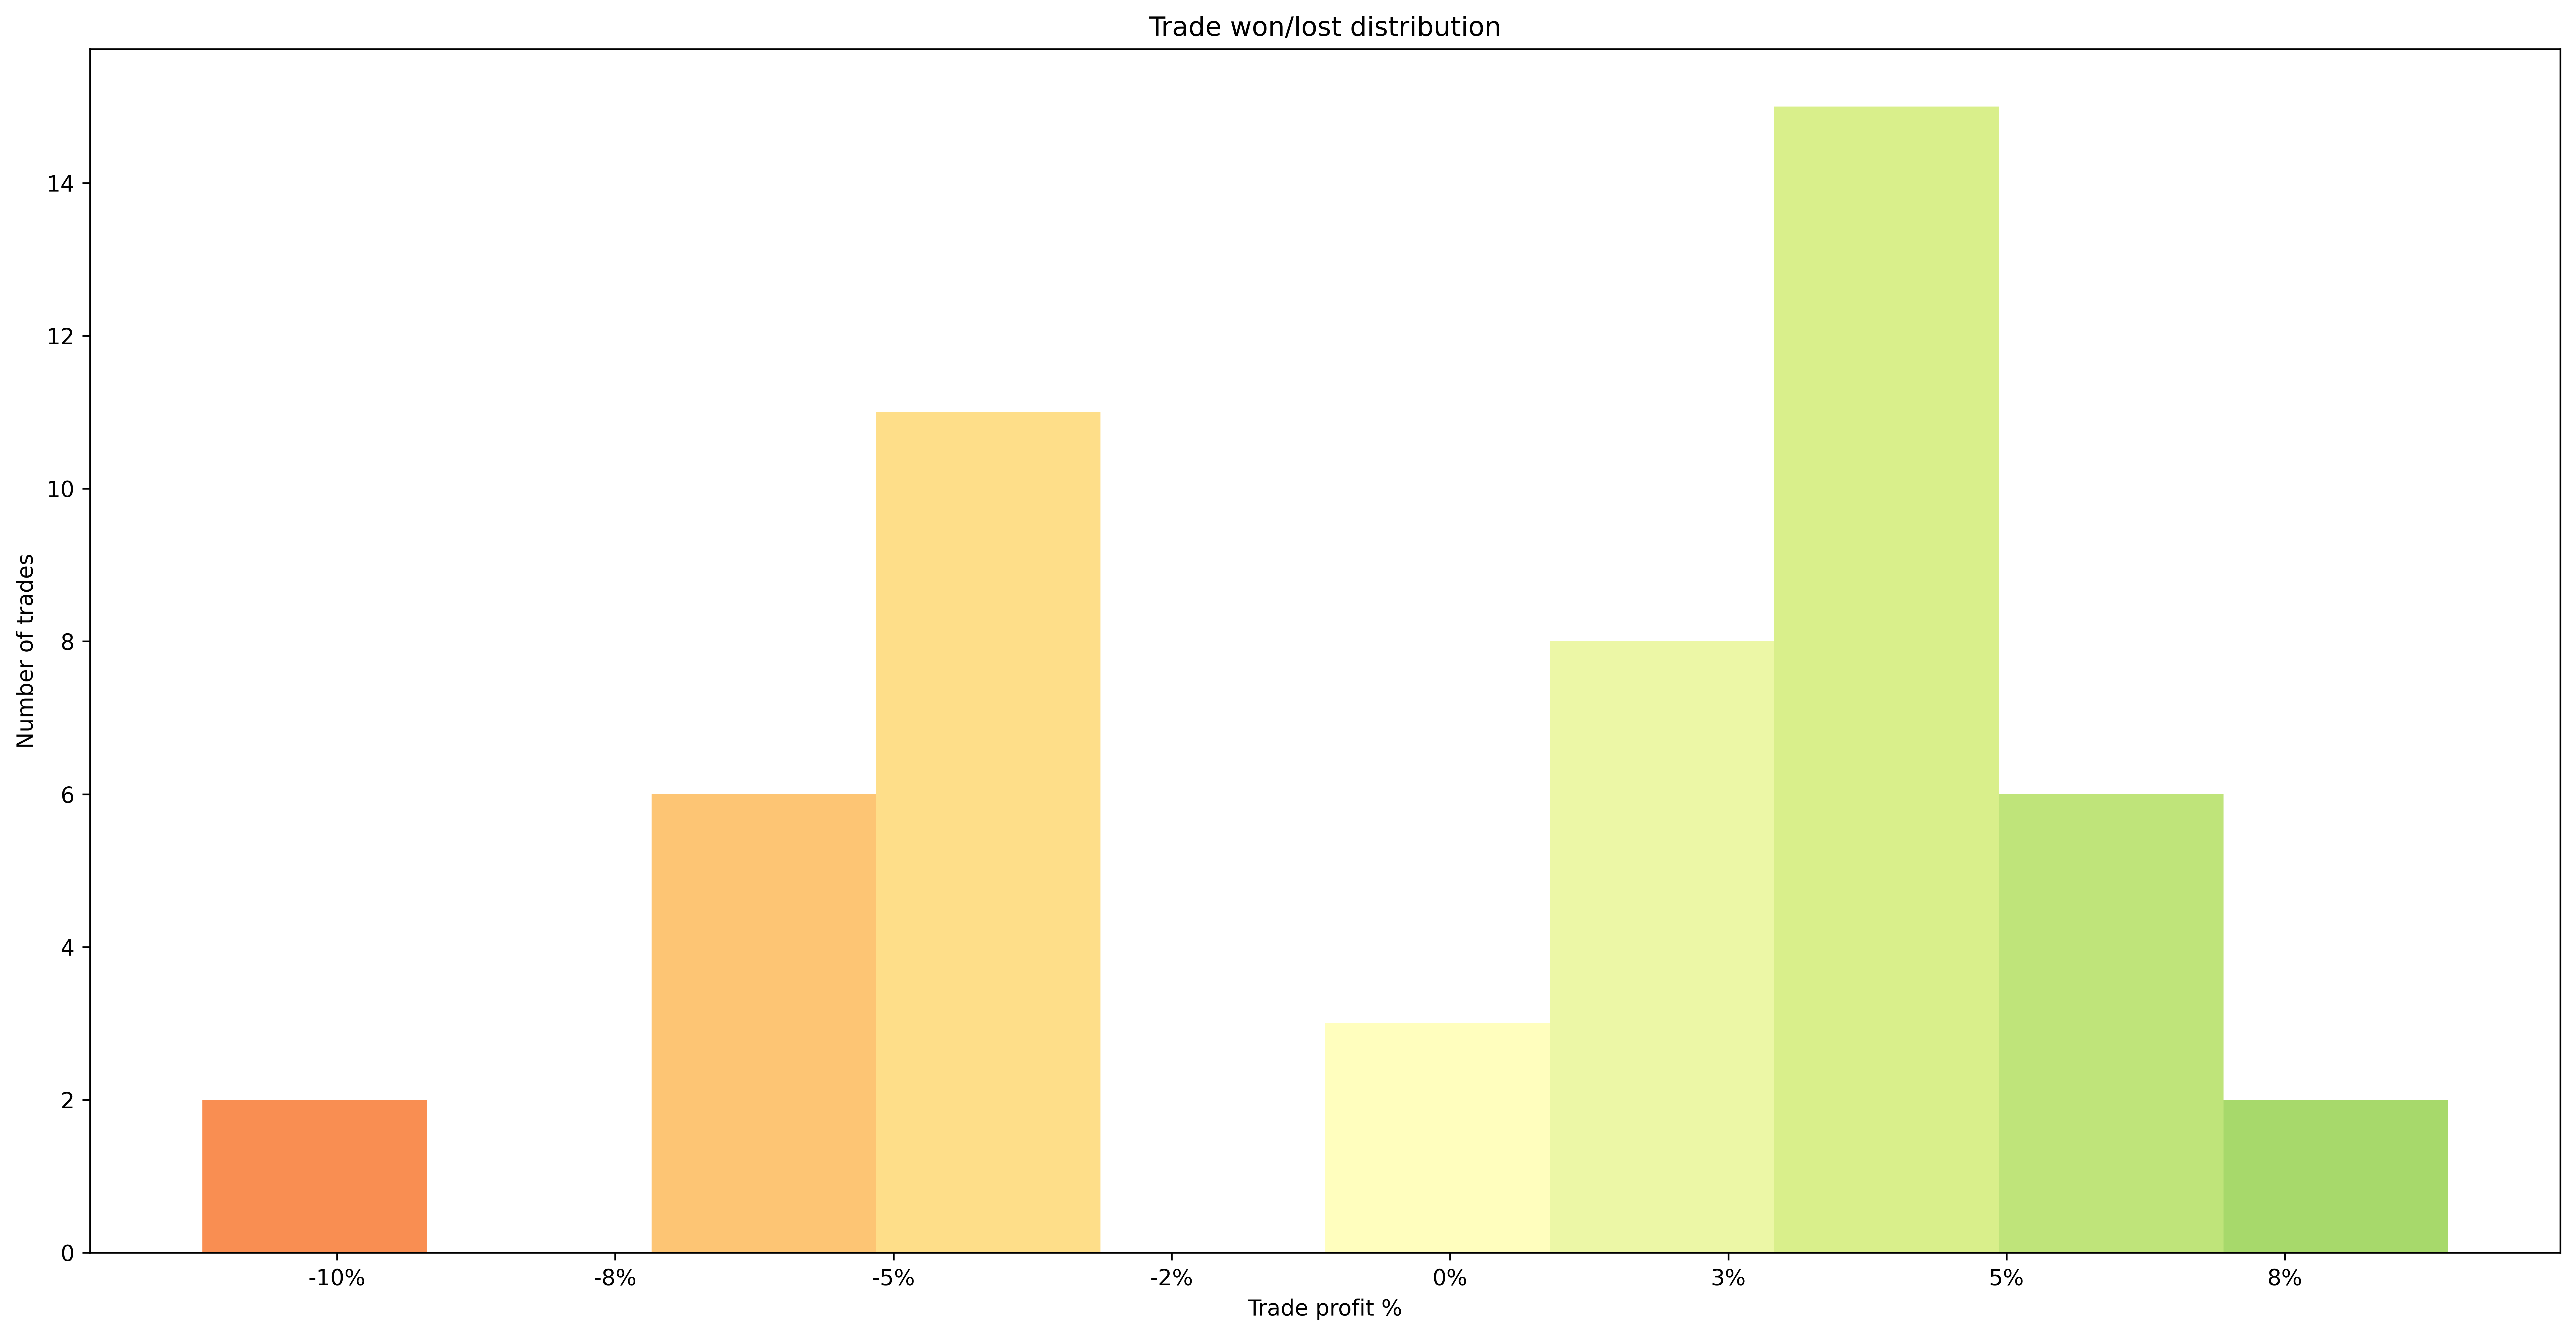

In [13]:
from matplotlib.figure import Figure
from tradingstrategy.analysis.tradeanalyzer import expand_timeline
from tradingstrategy.analysis.profitdistribution import plot_trade_profit_distribution

# Set the colors we use to colorise our PnL.
# You can adjust there colours to make the
# trade timeline more visual.
# These colors are later used in the trade timeline table.
vmin = -0.10  # Extreme red if -15% PnL
vmax = 0.10  # Extreme green if 15% PnL

timeline = trade_analysis.create_timeline()
expanded_timeline, _ = expand_timeline(exchange_universe, pair_universe, timeline)

fig: Figure = plot_trade_profit_distribution(
    expanded_timeline,
    bins=10,
    vmin=vmin,
    vmax=vmax)

### Chart analysis

The Backtrader default output chart will display the portfolio value
develoment and when the individual trades were made.

In [10]:
import datetime
import matplotlib.pyplot as pyplot

# Increase the size of the chart to be more readable,
# look better on high DPI monitor output
pyplot.rcParams['figure.figsize'] = [20, 10]

# We can cut the head period of the backtesting away,
# as there aren't any trades until the first moving average time period is complete
trading_begins_at = (BACKTESTING_BEGINS + MOVING_AVERAGE_CANDLES * datetime.timedelta(days=1)).date()

# Get all produced figures (one per strategy)
figs = cerebro.plot(iplot=True, start=trading_begins_at)

<IPython.core.display.Javascript object>

### Trading timeline

The timeline displays individual trades the strategy made. This is good for figuring out some really stupid trades the algorithm might have made.

In [11]:
from tradingstrategy.analysis.tradeanalyzer import expand_timeline

# Generate raw timeline of position open and close events
timeline = trade_analysis.create_timeline()

# Because this is s a single strategy asset,
# we can reduce the columns we render in the trade summary
hidden_columns = [
    "Id",
    "PnL % raw",
    "Exchange",
    "Base asset",
    "Quote asset"
]

# Expand timeline with human-readable exchange and pair symbols
expanded_timeline, apply_styles = expand_timeline(
    exchange_universe,
    pair_universe,
    timeline,
    vmin,
    vmax,
    hidden_columns)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Remarks,Opened at,Duration,PnL USD,PnL %,Open price USD,Close price USD
,2020-10-12 12:00:00,4 hours,$21.33,5.83%,$365.994141,$387.321564
SL,2020-10-13 20:00:00,2 days 16 hours,$-9.51,-2.52%,$377.560028,$368.049042
,2020-10-23 16:00:00,1 days,$2.91,0.71%,$411.332764,$414.243042
SL,2020-10-25 08:00:00,1 days 8 hours,$-16.73,-4.08%,$410.131653,$393.398254
,2020-11-07 20:00:00,1 days 4 hours,$26.99,6.28%,$429.797485,$456.788483
,2020-11-09 16:00:00,1 days 8 hours,$12.91,2.95%,$437.392090,$450.298676
,2020-11-12 20:00:00,16 hours,$10.70,2.35%,$454.962341,$465.658234
SL,2020-11-14 12:00:00,1 days 8 hours,$-12.92,-2.83%,$456.952576,$444.029358
,2020-11-18 20:00:00,1 days 8 hours,$14.03,2.98%,$470.502411,$484.529358
SL,2020-11-25 04:00:00,1 days,$-53.51,-9.15%,$585.086060,$531.575378


## Conclusion

The strategy profits > 10% start to be meaningful, and this strategy is less a toy strategy anymore.
There are a lot of further optimisations we can try and will try in the next notebook.